# Exercise: multi-class text classification on Stack Overflow questions

In this notebook, I attempt to modify the work done in `tf_basic_text_recognition.ipynb` to perform multi-class recognition. This exercise was proposed as a follow up to the [basic tutorial](https://www.tensorflow.org/tutorials/keras/text_classification/).


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


## Download data

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')


In [4]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow')
os.listdir(dataset_dir)

['test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

Similarly to the base tutorial, let's see an example:

In [7]:
sample_file = os.path.join(train_dir, 'python/100.txt')
with open(sample_file) as f:
    print(f.read())

"blank syntax doubt hey, i have been using the pymt library and they have this convention to referring their widgets:..from pymt import *..# create a slider from 0.-1..sl = mtxyslider()..@sl.event.def on_value_change(x, y):.    print 'slider value change', x, y..runtouchapp(sl)...what's with the ""@""? what does it signify in blank?thanks."



Let's split the dataset into train and validation:

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As before, we iterate over the dataset and print out a few examples:

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

And what are the labels? Respectively: 0, 1, 2 and 3.

In [10]:
print(raw_train_ds.class_names)

['csharp', 'java', 'javascript', 'python']


Validation and test sets:

In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/test/',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


## Preprocess data

Let's start with the process of standardization, tokenization and vectorization. It seems to me that we do not need to remove tags. So we can use a normal standardization (see the help page for [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)).

In [12]:
max_features=10000
sequence_length=250

vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

Then it's time to call `adapt`:

In [13]:
train_text = raw_test_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

We don't need to visualize the transformed data, we know what happens now. However, we still create the function to output the vectorized text:

In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

And finally let's vectorize all the sets:

In [15]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

We optimize the dataset for performance:

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Train data

We use the same model as before with `Embedding`, `GlobalAveragePooling1D` and a final `Dense` layer which will output 4 variables instead of 1. With an intermediate `Dense` layer with 16 nodes the model goes in overfit very fast (after 5 epochs of training already.). I try here with 32 nodes, but with similar results. It is very difficult to reach a good result here.

In [58]:
embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(32),
    layers.Dense(4)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_10 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_6   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 4)                 132       
                                                      

### Compilation
Because this is a multi-class classification problem, we need to use `SparseCategoricalCrossentropy` as a loss function. Equally, we will use `['accuracy']` as metrics, since `BinaryAccuracy` is only for binary classification.

In [59]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### Training!
After testing some, it seems that 15-20 epochs hits the spot when it comes to overfitting.

In [60]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
200/200 [==============================] - 2s 8ms/step - loss: 1.3761 - accuracy: 0.3091 - val_loss: 1.3478 - val_accuracy: 0.4575
Epoch 2/20
200/200 [==============================] - 1s 6ms/step - loss: 1.2545 - accuracy: 0.4930 - val_loss: 1.0962 - val_accuracy: 0.6400
Epoch 3/20
200/200 [==============================] - 1s 6ms/step - loss: 0.9711 - accuracy: 0.6356 - val_loss: 0.8419 - val_accuracy: 0.6913
Epoch 4/20
200/200 [==============================] - 1s 6ms/step - loss: 0.7809 - accuracy: 0.7117 - val_loss: 0.7155 - val_accuracy: 0.7362
Epoch 5/20
200/200 [==============================] - 1s 6ms/step - loss: 0.6604 - accuracy: 0.7636 - val_loss: 0.6318 - val_accuracy: 0.7681
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 0.5671 - accuracy: 0.8025 - val_loss: 0.5777 - val_accuracy: 0.7925
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.4953 - accuracy: 0.8314 - val_loss: 0.5377 - val_accuracy: 0.8019
Epoch 

And we proceed directly to evaluation:

In [61]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 3ms/step - loss: 0.6782 - accuracy: 0.7922
Loss:  0.6781579256057739
Accuracy:  0.7922499775886536


With 20 epochs, have a good accuracy of around 77-78%. Let's see accuracy and loss graphs.

In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

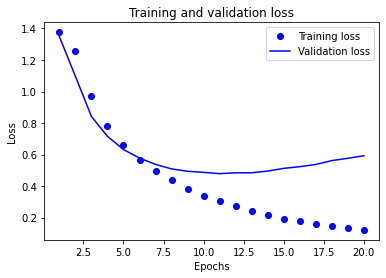

In [63]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

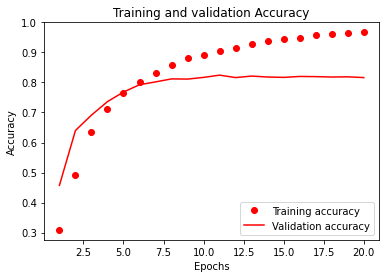

In [64]:
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Conclusion
This was a fun exercise and made me more at ease with text recognition. I look forward to being able to apply this to more advanced examples. The addition of a dense layer before the last one, while interesting, was also lots of work for very little gain (of the order of 1-2%). I will have to study more to understand in what direction to take my model building skills.